### Apache 2.0 License

In [1]:
"""
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

'\nLicensed under the Apache License, Version 2.0 (the "License");\nyou may not use this file except in compliance with the License.\nYou may obtain a copy of the License at\n\n    http://www.apache.org/licenses/LICENSE-2.0\n\nUnless required by applicable law or agreed to in writing, software\ndistributed under the License is distributed on an "AS IS" BASIS,\nWITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\nSee the License for the specific language governing permissions and\nlimitations under the License.\n'

### Importing Core Imaging Library

In [1]:
%load_ext autoreload
%autoreload 2
import cil
print(f'cil.__version__ = {cil.__version__}')

cil.__version__ = 24.3.0


### Import all the necessary libraries for the reconstruction

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cil.framework import AcquisitionGeometry
from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.plugins.astra import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
from cil.io import TIFFStackReader

/home/santtalainen/miniconda3/envs/cil/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Read keyboard PCA datafile for parameters

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from util.pcaReader import read_pca_file

filepath = '../keyboard_1/keyboard.pca'
params = read_pca_file(filepath)

196 lines, found 143 values (discarded 124)


Scan setting

In [4]:
SOD = params['FOD'] # Source-Origin-distance
SDD = params['FDD'] # Source-Detector-distance
ODD = SDD - SOD # Origin-Detector-distance

print(f'SOD: {SOD:.3f} mm')
print(f'SDD: {SDD:.3f} mm')
print(f'ODD: {ODD:.3f} mm')

pixel_size = 200 / 1000
print(f'Detector pixel size: {pixel_size:.3f} mm')

num_pixels = (params['DimX'], params['DimY']) # Width and height of the projection image
num_pixels = (num_pixels[0], num_pixels[1])
print(f'The original size of the projection image: {params['DimX']} x {params['DimY']}, set to {num_pixels[0]} x {num_pixels[1]}')

# Projections
num_projs = params['NumberImages']
print(f'{num_projs} projection angles used')


SOD: 150.595 mm
SDD: 648.629 mm
ODD: 498.035 mm
Detector pixel size: 0.200 mm
The original size of the projection image: 1000.0 x 1000.0, set to 1000.0 x 1000.0
1080 projection angles used


Detector and rotation angles

In [5]:
skip = 10 # Donwsampling constant for projections
angles = np.linspace(0, 360, num_projs//skip, endpoint=False) # Downsampled angles

ag_big = AcquisitionGeometry.create_Cone3D(
    source_position=[0, -SOD, 0],
    detector_position=[0, ODD, 0],
    units='mm',
    detector_direction_x=[1, 0, 0],
    rotation_axis_direction=[0,0,1],  
)

ag_big.set_panel(
    num_pixels=num_pixels,
    pixel_size=(pixel_size,pixel_size),
    origin='bottom-right'
    )

ag_big.set_angles(angles)
ag_big.set_labels(('angle', 'vertical', 'horizontal'))
print(ag_big)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -150.59470833,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 498.03460667,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


Read the .tif files

Number of dimensions: 3
Shape: (108, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



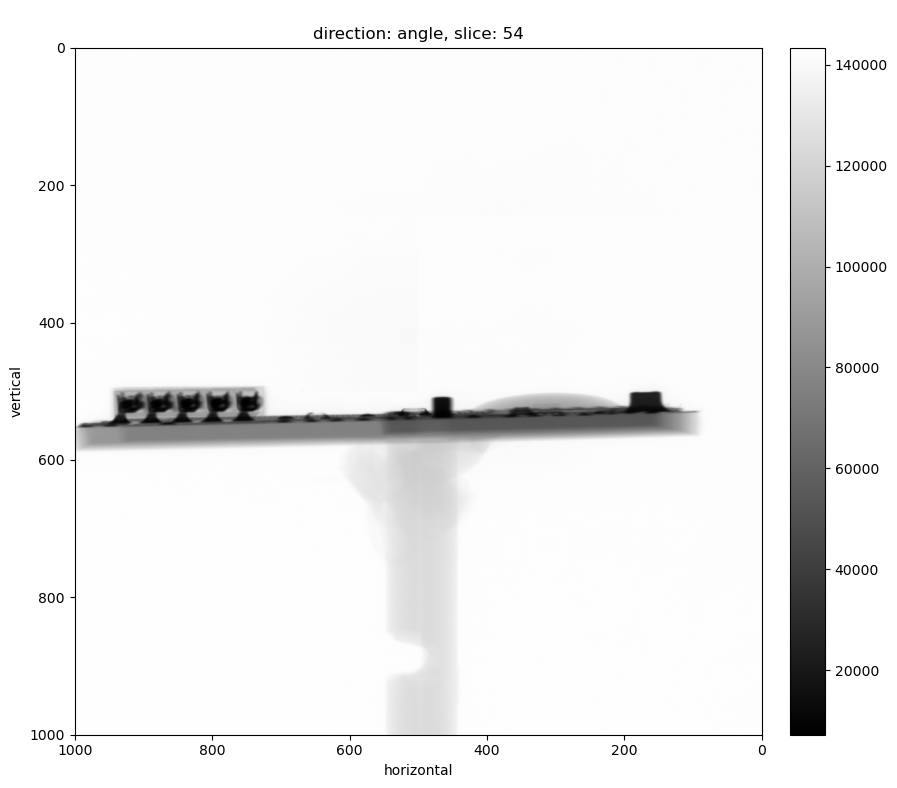

In [6]:
# Region of interest
roi = {'axis_0': (0, num_projs, skip), 'axis_1': -1, 'axis_2': (0, 1000,1)}
reader = TIFFStackReader(file_name='../keyboard_1', transpose=False, roi=roi)
big_raw_data = reader.read_as_AcquisitionData(ag_big)
del reader
print(big_raw_data)
show2D(datacontainers=big_raw_data, origin='upper-right');

Processing transmission images to absorption images

max_k = 14357, about 87.628 of the maximum (of 14 bit int)


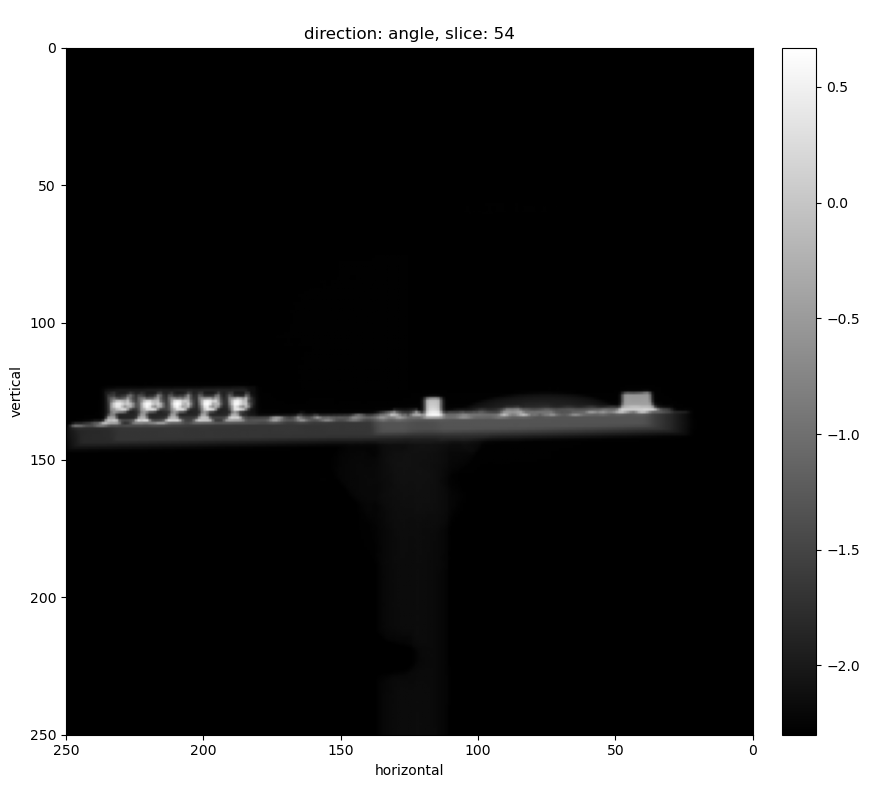

Number of dimensions: 3
Shape: (108, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [7]:
from cil.processors import Binner, TransmissionAbsorptionConverter

binning = 4 # Downsampling parameter
binner_processor = Binner(roi={'horizontal': (None, None, binning), 'vertical': (None, None, binning)})
binner_processor.set_input(big_raw_data)

# Binned data
data = binner_processor.get_output()

max_k = params['FreeRay'] # Maximum intensity
# max_k = data.as_array().max() # Maximum intensity in the binned data
# max_k = 16000
print(f'{max_k = }, about {100*max_k / 2**14:.3f} of the maximum (of 14 bit int)')
transmission_processor = TransmissionAbsorptionConverter(white_level=max_k)
# transmission_processor = TransmissionAbsorptionConverter()
transmission_processor.set_input(data)
transmission_processor.get_output(out=data)

show2D(data, origin='upper-right')
print(data)

Fanbeam sinogram of the central slice

Sinogram Data:
Number of dimensions: 2
Shape: (108, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



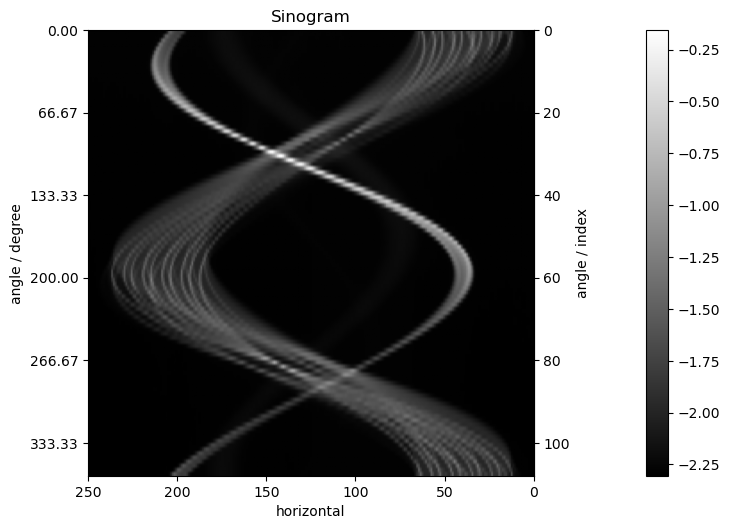

In [8]:
# fan_sinogram = data.get_slice(vertical=131, force=True)
# data.reorder('tigre')
# fan_sinogram = data.get_slice(vertical='centre')
fan_sinogram = data.get_slice(vertical=125, force=True)

print("Sinogram Data:")
print(fan_sinogram)
show2D(fan_sinogram, size=(10,10), origin='upper-right', title='Sinogram');

In [155]:
print(fan_sinogram.geometry.angles.shape)
print(fan_sinogram.as_array().shape)
print(fan_sinogram.geometry)
# print(dir(fan_sinogram.geometry))
print(fan_sinogram.geometry.dist_center_detector)
print(fan_sinogram.geometry.dist_source_center)
print(type(fan_sinogram.as_array()))


(108,)
(108, 250)
2D Cone-beam tomography
System configuration:
	Source position: [   0.        , -150.59470833]
	Rotation axis position: [0., 0.]
	Detector position: [  0.        , 498.03460667]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [250   1]
	Pixel size: [0.8 0.8]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 108
	Angles 0-9 in degrees: [ 0.       ,  3.3333333,  6.6666665, 10.       , 13.333333 , 16.666666 ,
 20.       , 23.333334 , 26.666666 , 30.       ]
	Angles 98-107 in degrees: [326.66666, 330.     , 333.33334, 336.66666, 340.     , 343.33334,
 346.66666, 350.     , 353.33334, 356.66666]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm
498.03460667
150.59470833
<class 'numpy.ndarray'>


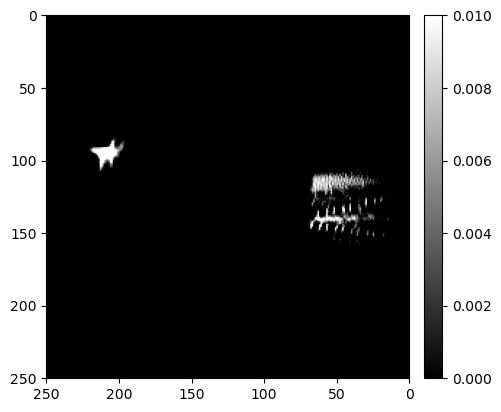

In [10]:
from skimage.transform import iradon
test_recon = iradon(fan_sinogram.as_array().T, theta=data.geometry.angles, filter_name='ramp', interpolation='nearest')
show2D(test_recon, size=(8,8), origin='upper-right', fix_range=(0,.01));


Beta (degrees): 0.0, 356.6666564941406
Gamma (degrees): 0.035333446037591094
theta (degrees): 0.035333446037591094
s (mm): 0.09286948721667976
s_gamma_max (mm): 22.856608626421796
Detector t (mm): [-99.6 -98.8 -98.  -97.2 -96.4] ... [96.4 97.2 98.  98.8 99.6]
Gamma (deg): [-8.72984169 -8.66078991 -8.59171278 -8.52261047 -8.45348318] ... [8.45348318 8.52261047 8.59171278 8.66078991 8.72984169]
s_parallel (mm): [-22.85660863 -22.67720083 -22.49769419 -22.31808941 -22.13838721] ... [22.13838721 22.31808941 22.49769419 22.67720083 22.85660863]
Performing 2D interpolation... (this may take a moment)
Interpolation complete.


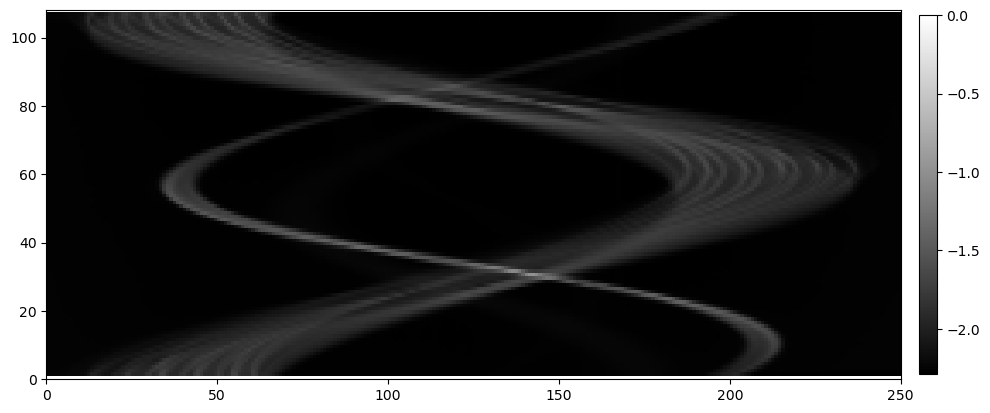

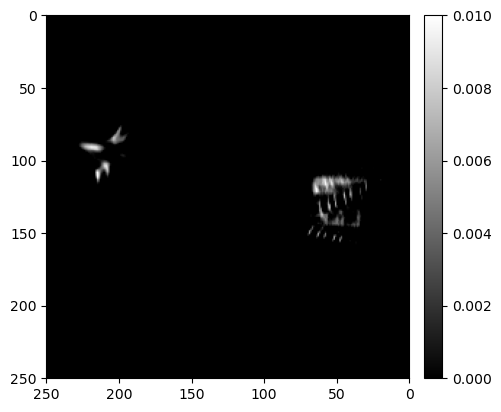

In [11]:
# %reload_ext util/fan2par.py

from skimage.transform import iradon
from util.fan2par import rebin_fan_to_parallel
# print(fan_sinogram.geometry.pixel_size_h)

fan_sinogram_np = fan_sinogram.as_array()
# print(fan_sinogram_np.shape)
# print(np.asarray(fan_sinogram))

parallel_sinogram, parallel_theta = rebin_fan_to_parallel(fan_sinogram, fan_sinogram.geometry)
show2D(parallel_sinogram, size=(10,10))
# print(parallel_sinogram)

recon = iradon(
    parallel_sinogram.T,
    theta=parallel_theta,
    filter_name='ramp',
    interpolation='linear'
)
# show2D(recon, size=(8,8), origin='upper-right');
show2D(recon, size=(8,8), origin='upper-right', fix_range=(0, .01));


Performing interpolation with map_coordinates...
Interpolation complete.


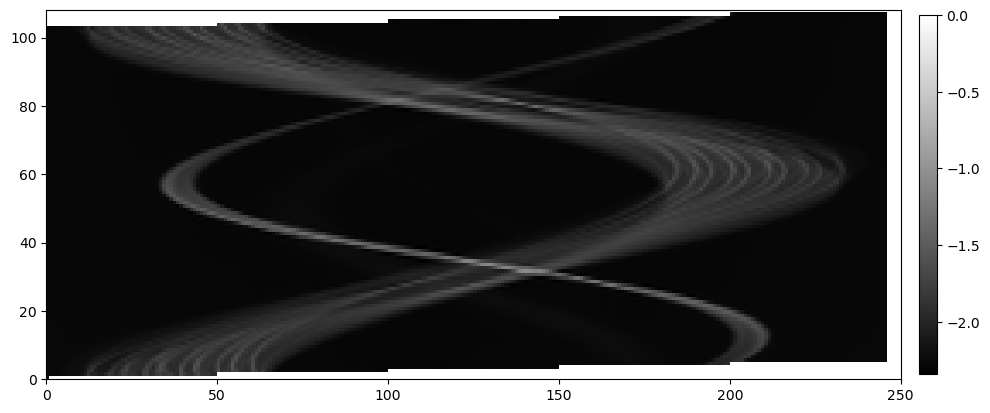

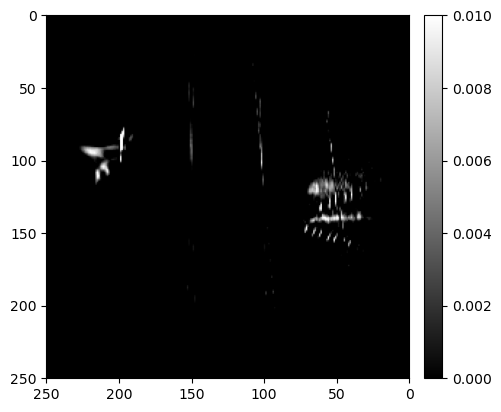

In [12]:
from util.fan2par import rebin_fan_to_parallel_map_coords

para_sino, para_theta = rebin_fan_to_parallel_map_coords(fan_sinogram, fan_sinogram.geometry)
show2D(para_sino, size=(10,10))
# print(parallel_sinogram)

recon = iradon(
    para_sino.T,
    theta=para_theta,
    filter_name='ramp',
    interpolation='linear'
)
# show2D(recon, size=(8,8), origin='upper-right');
show2D(recon, size=(8,8), origin='upper-right', fix_range=(0, .01));


In [13]:
from cil.recon import FBP
from cil.framework import AcquisitionData

agp = AcquisitionGeometry.create_Parallel2D() \
    .set_angles(parallel_theta) \
    .set_panel(num_pixels=250, pixel_size=0.8)

ig = agp.get_ImageGeometry()
# print(ig)

acq_data = AcquisitionData(geometry=agp, data=parallel_sinogram);

fbp = FBP(acq_data)
out = fbp.run()
# show2D(out)
# print(out.as_array())

FBP recon

Input Data:
	angle: 108
	horizontal: 250

Reconstruction Volume:
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



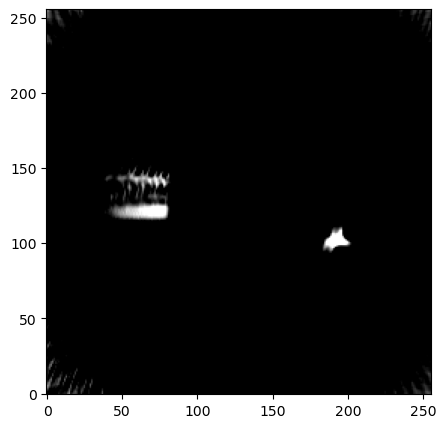

In [14]:
import astra

angles_rad = np.deg2rad(parallel_theta)
# angles_rad = np.deg2rad(np.linspace(0,356.6666564941406, 108, endpoint=False))
M = 256



vol_geom = astra.create_vol_geom(M, M)
n_detectors = parallel_sinogram.shape[1]
pixel_size = fan_sinogram.geometry.pixel_size_h
proj_geom = astra.create_proj_geom(
    'parallel',
    pixel_size,
    n_detectors,
    angles_rad
)


# sinogram_id = astra.data2d.create('-sino', proj_geom, parallel_sinogram)
sinogram_id = astra.data2d.create('-sino', proj_geom, fan_sinogram_np)

rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('FBP_CUDA')
# cfg = astra.astra_dict('EM_CUDA')
# cfg = astra.astra_dict('SIRT_CUDA')
# cfg = astra.astra_dict('SART_CUDA')
# cfg = astra.astra_dict('CGLS_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
# cfg['option'] = { }
# cfg['option']['ProjectionOrder'] =  'custom'
# # set projection order to 0, 5, 10, ..., 175, 1, 6, 11, ...., 176, 2, 7, .....
# cfg['option']['ProjectionOrderList'] = np.array(range(180)).reshape(-1,5).T.reshape(-1)

# cfg['FilterType'] = 'Shepp-Logan'


alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 100)

recon_fbp = astra.data2d.get(rec_id)

astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)

plt.figure(figsize=(5,5))
plt.imshow(recon_fbp, cmap='gray', vmin=0, vmax=0.01, origin='lower')
# plt.imshow(recon_fbp, cmap='gray', origin='lower')
plt.show()


Using 'cycle' coverage. Padding sinogram data to fill corners.


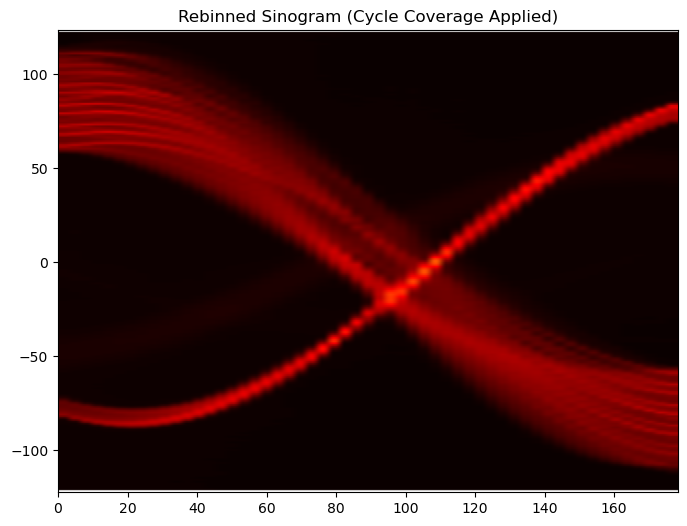

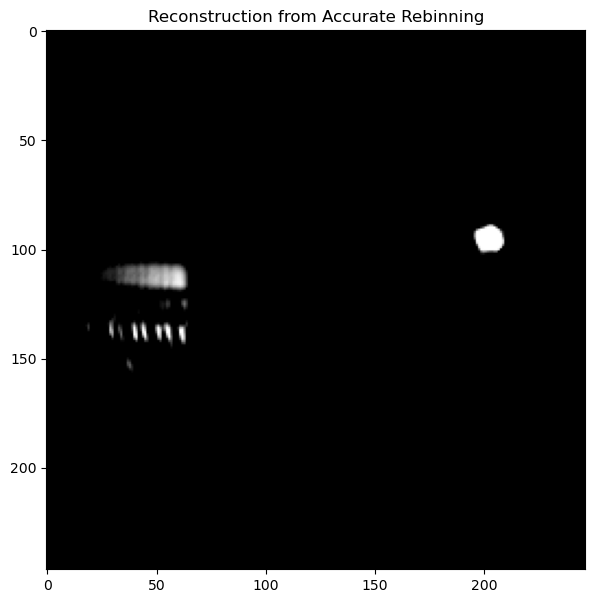

In [154]:
from util.fan2par import fan2para

D_pixel_size = params['PixelsizeX']

P, Ploc, Pangles = fan2para(
    fan_sinogram_np,
    D_pixels= SOD/D_pixel_size,
    FanSensorGeometry='line',
    FanSensorSpacing=1.0,
    FanRotationIncrement=3.3024690416124134
)

plt.figure(figsize=(8,6))
plt.imshow(P,
           extent=[Pangles[0], Pangles[-1], Ploc[0], Ploc[-1]],
           aspect='auto',
           cmap='hot')
plt.title("Rebinned Sinogram (Cycle Coverage Applied)")
plt.show()

# The reconstruction should also be correct
recon_mb = iradon(P, Pangles, filter_name='hann', interpolation='linear')

plt.figure(figsize=(7,7))
plt.imshow(recon_mb, cmap='gray', vmin=0, vmax=0.01)
plt.title("Reconstruction from Accurate Rebinning")
plt.show()

2D Reconstruction of a single sinogram slice with FDK algorithm

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250
voxel_size : x0.1857390097516638,y0.1857390097516638
center : x0,y0



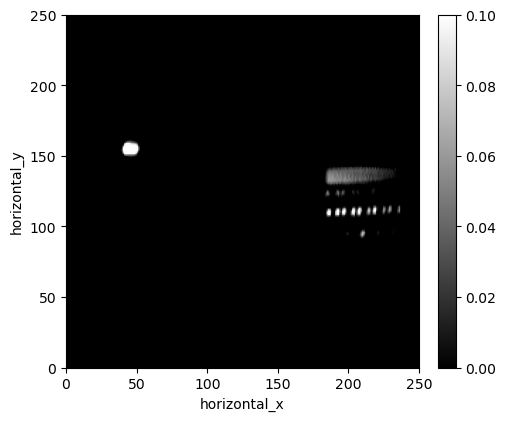

In [15]:
from cil.plugins.astra.processors import FBP

print(fan_sinogram.geometry.get_ImageGeometry())

fdk2d = FBP(image_geometry=fan_sinogram.geometry.get_ImageGeometry(), acquisition_geometry=fan_sinogram.geometry, device='gpu')
fdk2d.set_input(fan_sinogram)
fdk2d_recon = fdk2d.get_output()
show2D(fdk2d_recon, size=(10,8), fix_range=(0,.1));
# show2D(fdk2d_recon, size=(10,8)); # Reconstruction without fixed color range

# print(fan_sinogram.geometry.angles)


/home/santtalainen/miniconda3/envs/cil/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


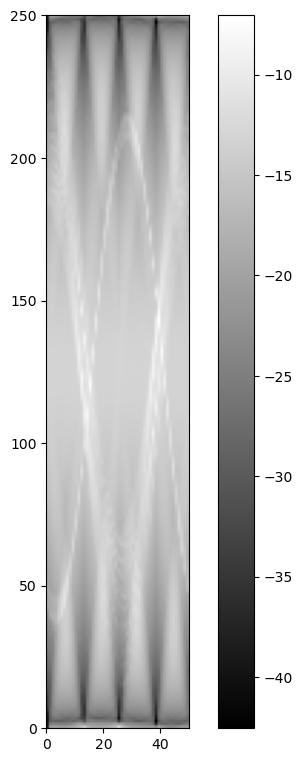

<class 'numpy.ndarray'>


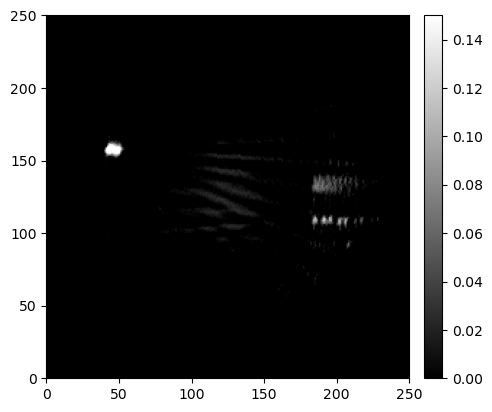

(50,)
(250, 50)


In [16]:
from skimage.transform import radon

theta = np.linspace(0,356.6666564941406, 108, endpoint=False)
# theta = fan_sinogram.geometry.angles

par_sinogram = radon(fdk2d_recon.as_array(), theta=theta)
show2D(par_sinogram)
print(type(par_sinogram))
recon_radon = iradon(par_sinogram, theta=theta, filter_name='shepp-logan', interpolation='nearest')
show2D(recon_radon, fix_range=(0, 0.05), size=(8,8));


print(theta.shape)
print(par_sinogram.shape)

In [87]:
import h5py

output_file = 'parallel_beam_data_for_julia.h5'

with h5py.File(output_file, 'w') as f:
    f.create_dataset('sinogram', data=par_sinogram.T)
    f.create_dataset('angles', data=theta)

In [17]:
from scipy.io import savemat

# savemat('fan_sinogram.mat', {'fan_sinogram': fan_sinogram_np})

savemat('data.mat', {
    'fan_sinogram': fan_sinogram_np,
    'SOD': SOD,
    'SDD': SDD,
    'ODD': ODD,
    'pixel_sz': pixel_size
})

In [ ]:
# Tomopy for parallel beam transform
# import astra

# Angles of the sinogram
angles_rad = fan_sinogram.geometry.angles

det_spacing_X = fan_sinogram.geometry.pixel_size_h
num_det = fan_sinogram.geometry.pixel_num_h

# print(f'Det space: {det_space} and Num_det: {num_det}')
fan_sinogram_np = fan_sinogram.as_array()


import h5py

output_file = 'fanbeam_sinogram_for_julia.h5'


with h5py.File(output_file, 'w') as f:
    f.create_dataset('sinogram', data=fan_sinogram_np)
    f.create_dataset('angles', data=angles_rad)



(90, 250)


In [31]:
islicer(data, direction=0)
# show2D(data, origin='upper-right')


In [13]:
# Delete unnecessary thing to free memory
del big_raw_data
del binner_processor
del transmission_processor

Image geometry

In [18]:
# Setup for the image geometry
(_, nz, nx) = data.shape

# Image geometry
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.1857390097516638,y0.1857390097516638,z0.1857390097516638
center : x0,y0,z0



### CT-reconstructions

Feldkamp-Davis-Kress (FDK) reconstruction algorithm

In [19]:

from cil.recon import FDK

# data.reorder('tigre')
data.reorder('tigre')
fdk = FDK(data, image_geometry=ig, filter='ram-lak')
fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 108
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



(250, 250, 250)


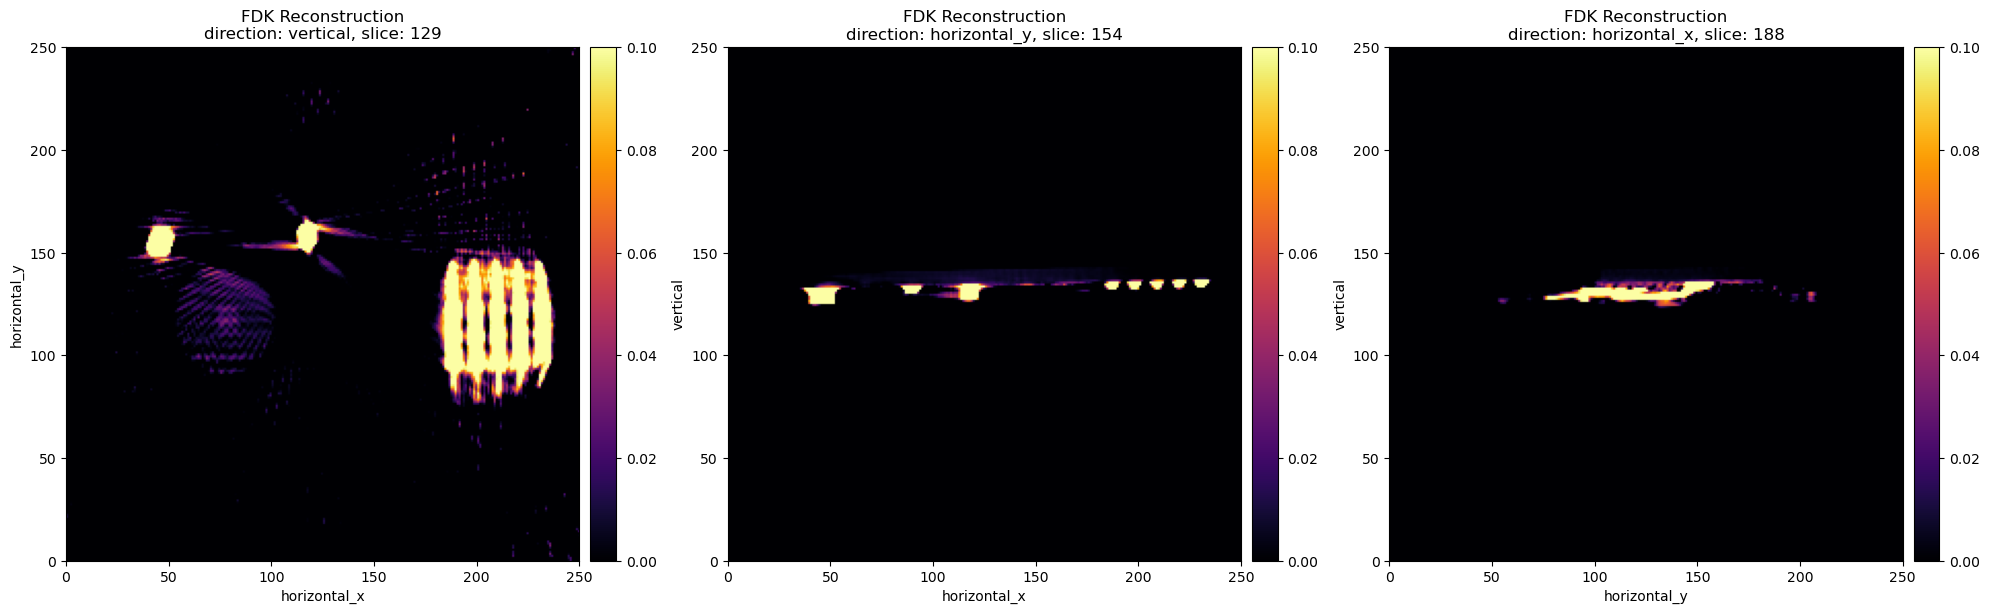

In [ ]:
lb = 0 # lower bound
ub = .1 # upper bound
print(fdk_recon.shape)
show2D(fdk_recon, size=(20,10), fix_range=(lb,ub), cmap='inferno', title=f'FDK Reconstruction', num_cols=3, slice_list=[(0, 128), (1, 154), (2, 188)]);

In [70]:
islicer(fdk_recon, minmax=(lb,ub), direction=0, cmap='gray')


Iterative reconstruction using Total Variation (TV) and FISTA algorithm.

In [69]:
data.reorder('astra') # Changing backend

# Acquisition geometry
ag = data.geometry

A = ProjectionOperator(ig, ag, 'gpu')
f = LeastSquares(A, data)
h = TotalVariation()
x0 = ig.allocate(0) # Starting point

# alpha = 1e-5 # Regulazation constant
alpha = 0.02

tv_fista = FISTA(initial=x0, f=f, g=alpha*h) # Setting up FISTA algorithm

tv_fista.run(20)

  0%|          | 0/20 [00:00<?, ?it/s]

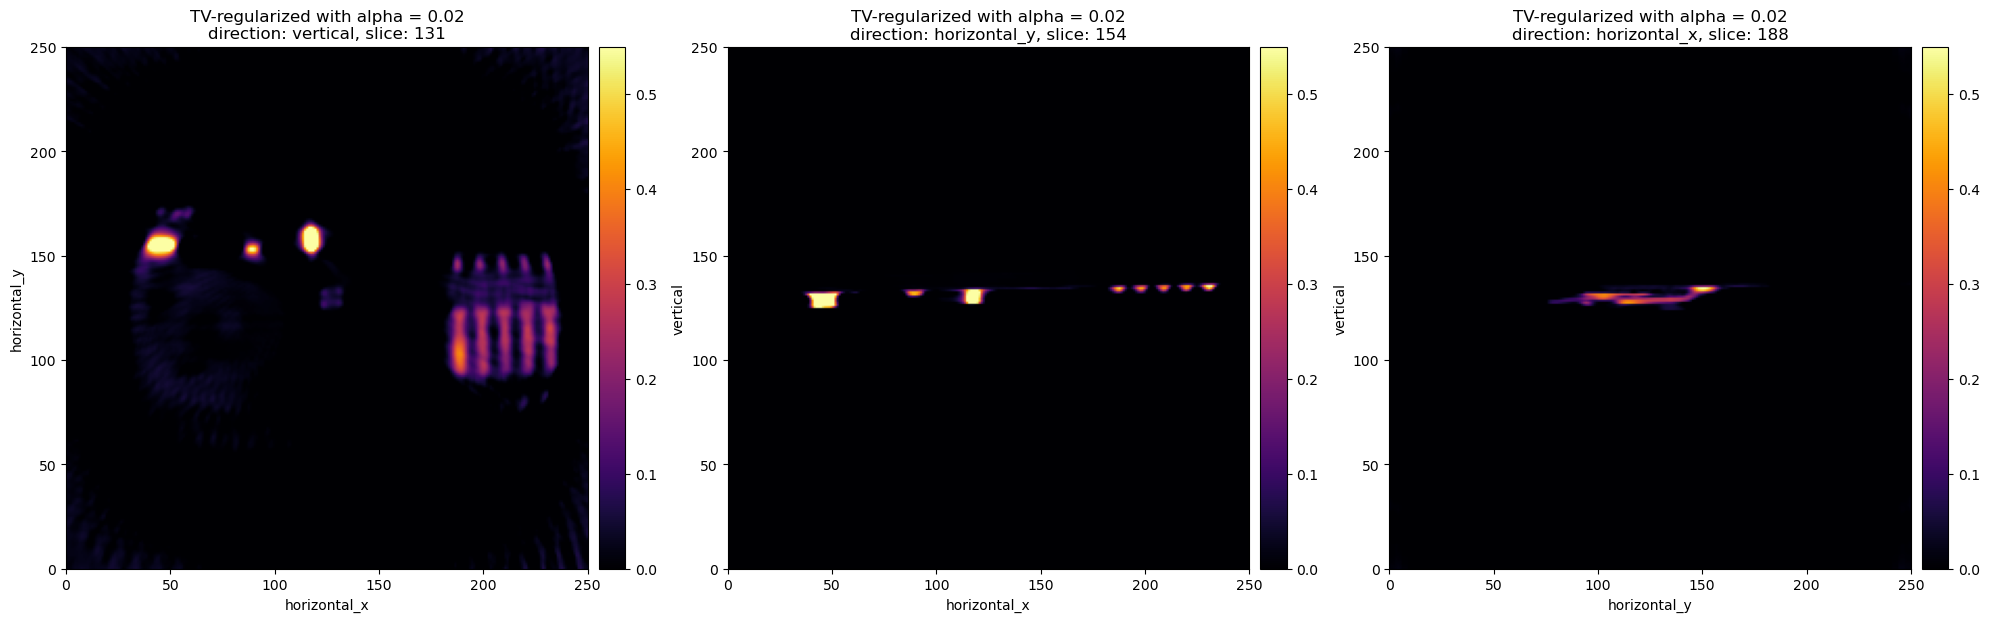

In [78]:
ub = .55
x_tv = tv_fista.get_output()
show2D(x_tv, size=(20, 10), fix_range=(lb,ub), cmap='inferno', title=f'TV-regularized with {alpha = }', num_cols=3, slice_list=[(0, 131), (1, 154), (2, 188)]);